## **1. Task of the project :**

## **2. Data :**

In [2]:
import zipfile
from PIL import Image
import io
import os
from sklearn.model_selection import train_test_split
import shutil
from keras.preprocessing.image import ImageDataGenerator

# Path to the zip file
zip_file_path = "Dataset_all.zip"

# Temporary extraction folder
extracted_folder_path = "extracted_data"

# Create the extraction folder if it doesn't exist
os.makedirs(extracted_folder_path, exist_ok=True)


# 1. Ensure proper error handling during data extraction
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder_path)
except zipfile.BadZipFile:
    print("Error: The provided zip file is invalid.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")
    # Handle other potential exceptions as needed
    # ...

# Paths to the "with_mask" and "without_mask" folders
with_mask_folder_path = os.path.join(extracted_folder_path, "data", "with_mask")
without_mask_folder_path = os.path.join(extracted_folder_path, "data", "without_mask")

In [3]:
# 2. Check Image Sizes and Handle Issues during Loading
def load_images(folder_path):
    images = []
    for file in os.listdir(folder_path):
        try:
            image = Image.open(os.path.join(folder_path, file))
            # Resize images to a consistent size if needed
            # image = image.resize((desired_width, desired_height))
            images.append(image)
        except (IOError, OSError) as e:
            print(f"Error loading image {file}: {e}")
            # Handle other potential image loading issues
            # ...

    return images

# Load images with proper error handling
with_mask_data = load_images(with_mask_folder_path)
without_mask_data = load_images(without_mask_folder_path)

In [4]:
print(f"With mask data :  {len(with_mask_data),type(with_mask_data)} \nWithout mask data : {len(without_mask_data)}")

With mask data :  (3725, <class 'list'>) 
Without mask data : 3828


In [5]:
# 3. Verification Data Splitting and Avoid Data Leakage
# Ensuring that the split maintains a representative distribution of classes
with_mask_train, with_mask_test = train_test_split(with_mask_data, test_size=0.25, random_state=42, stratify=[1]*len(with_mask_data))
without_mask_train, without_mask_test = train_test_split(without_mask_data, test_size=0.25, random_state=42, stratify=[0]*len(without_mask_data))

# Verify the size of the datasets
print(f"Training Data Size:\n with_mask_train : {len(with_mask_train)} \n without_mask_train : {len(without_mask_train)}")
print(f"Testing Data Size:\n with_mask_test : {len(with_mask_test)} \n without_mask_test : {len(without_mask_test)}")

Training Data Size:
 with_mask_train : 2793 
 without_mask_train : 2871
Testing Data Size:
 with_mask_test : 932 
 without_mask_test : 957


In [9]:
print(2793 + 932 , 2871 + 957)

3725 3828


In [6]:
# Temporary extraction folder
new_data_folder_path = "new_data"  #use "content/new_data" for Google colab
os.makedirs(new_data_folder_path, exist_ok=True)

# Train and Test Directories
train_dir_path = os.path.join(new_data_folder_path, "Train")
test_dir_path = os.path.join(new_data_folder_path, "Test")

# Create Train and Test Directories if they don't exist
os.makedirs(train_dir_path, exist_ok=True)
os.makedirs(test_dir_path, exist_ok=True)

# Paths for with_mask and without_mask folders in Train and Test
train_with_mask_path = os.path.join(train_dir_path, "with_mask")
train_without_mask_path = os.path.join(train_dir_path, "without_mask")
test_with_mask_path = os.path.join(test_dir_path, "with_mask")
test_without_mask_path = os.path.join(test_dir_path, "without_mask")

# Create with_mask and without_mask directories in Train and Test if they don't exist
os.makedirs(train_with_mask_path, exist_ok=True)
os.makedirs(train_without_mask_path, exist_ok=True)
os.makedirs(test_with_mask_path, exist_ok=True)
os.makedirs(test_without_mask_path, exist_ok=True)

In [7]:
# 4. Organize Code into Functions for Better Modularity
def organize_data(data, destination_dir):
    os.makedirs(destination_dir, exist_ok=True)
    for image in data:
        destination_path = os.path.join(destination_dir, os.path.basename(image.filename))
        shutil.copy(image.filename, destination_path)



# Move the images to the corresponding subdirectories in Train Dir
organize_data(with_mask_train, train_with_mask_path)
organize_data(without_mask_train, train_without_mask_path)

# Move the images to the corresponding subdirectories in Test Dir
organize_data(with_mask_test, test_with_mask_path)
organize_data(without_mask_test, test_without_mask_path)

# Verify the structure has been filled
print(f"Train Data Size:\n with_mask_tr : {len(os.listdir(train_with_mask_path))} \n without_mask_tr : {len(os.listdir(train_without_mask_path))}")
print(f"Test Data Size:\n with_mask_te : {len(os.listdir(test_with_mask_path))} \n without_mask_te : {len(os.listdir(test_without_mask_path))}")



Train Data Size:
 with_mask_tr : 2793 
 without_mask_tr : 2871
Test Data Size:
 with_mask_te : 932 
 without_mask_te : 957


In [11]:
# print(len(train),len(test))

## **4. Data Preprocessing :**

In [12]:
# Specify the paths for train and test data directories
train_data_dir = "new_data/Train"
test_data_dir = "new_data/Test"

# Create an ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,            # Rescale pixel values to the range [0, 1]
    rotation_range=20,          # Randomly rotate images in the range [0, rotation_range] degrees
    width_shift_range=0.1,      # Randomly shift images horizontally by a fraction of total width
    height_shift_range=0.1,     # Randomly shift images vertically by a fraction of total height
    shear_range=0.1,            # Shear intensity (shear angle in the counter-clockwise direction as radians)
    zoom_range=0.1,             # Randomly zoom into images by a fraction
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill in newly created pixels after rotation or width/height shift
)

# Create a generator for training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    batch_size=38,              # Number of samples in each batch
    target_size=(150, 150),      # Resize input images to this size
    class_mode='binary'         # Type of label to be used ('binary' for binary classification)
)

# Create an ImageDataGenerator for testing data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    batch_size=38,
    target_size=(150, 150),
    class_mode='binary'
)

Found 5664 images belonging to 2 classes.
Found 1889 images belonging to 2 classes.


In [29]:
# Get a batch of data from the generator
sample_batch = next(train_generator)

# Print the shapes of input data and labels
print("Input Shape:", sample_batch[0].shape)
print("Label Shape:", sample_batch[1].shape)

Input Shape: (38, 150, 150, 3)
Label Shape: (38,)


In [ ]:
# data  = with_mask_data + without_mask_data
# print(len(data), type(data))

7450 <class 'list'>


## **3. Importing neccessary modules :**

In [13]:
!pip install keras

In [14]:
!pip install tensorflow

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

## **5. Creating a model :**



**i. ANN :**

In [18]:
# Creating the Sequential model
model = Sequential([
    # First Convolutional layer with 100 filters, a 3x3 kernel, 'relu' activation, and input shape (150, 150, 3)
    Conv2D(100, (3, 3), activation='relu', input_shape=(150, 150, 3)),

    # MaxPooling layer with a 2x2 pool size
    MaxPooling2D(2, 2),

    # Second Convolutional layer with 100 filters and a 3x3 kernel, 'relu' activation
    Conv2D(100, (3, 3), activation='relu'),

    # Another MaxPooling layer with a 2x2 pool size
    MaxPooling2D(2, 2),

    # Flatten layer to convert the 3D output to 1D before passing to the Dense layers
    Flatten(),

    # Dropout layer to help prevent overfitting by randomly setting a fraction of input units to 0 at each update during training
    Dropout(0.5),

    # Dense (fully connected) layer with 50 neurons and 'relu' activation
    Dense(75, activation='relu'),

    # Output layer with 1 neurons (binary classification) and 'sigmoid' activation
    Dense(1, activation='sigmoid')
])


In [21]:
!pip install tensorflow-addons

     ------------------------------------ 719.8/719.8 kB 504.7 kB/s eta 0:00:00


## **6. Compiling & training & saving the model :**

In [32]:
from tensorflow.keras.metrics import Precision, Recall, AUC, Accuracy
from tensorflow_addons.metrics import F1Score
# Compile the model
model.compile(
    # Optimizer: Adam optimizer is commonly used for its adaptive learning rate capabilities
    optimizer='adam',

    # Loss function: Binary Crossentropy is suitable for binary classification tasks
    loss='binary_crossentropy',

    # Metrics to monitor during training: 'acc' represents accuracy
    metrics=["acc", Precision(), Recall(), AUC()]
)

In [53]:
# Set up callbacks for model saving and early stopping
model_checkpoint = ModelCheckpoint('FaceMask_Detection104.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

In [54]:
# Train the model
history = model.fit(
    # Training data generator
    train_generator,

    # Number of epochs: The number of times the model will iterate over the entire training dataset
    epochs=10,

    # Validation data generator: Used to evaluate the model's performance on a separate validation dataset
    validation_data=test_generator,
    
    callbacks=[model_checkpoint, early_stopping]
)


Epoch 1/10
103/150 [===================>..........] - ETA: 1:37 - loss: 0.2040 - acc: 0.9255 - precision_2: 0.9294 - recall_2: 0.9233 - auc_3: 0.9750

C:\Users\Sandip\anaconda3\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


150/150 [==============================] - ETA: 0s - loss: 0.1985 - acc: 0.9271 - precision_2: 0.9297 - recall_2: 0.9262 - auc_3: 0.9759
Epoch 1: val_loss improved from inf to 0.17453, saving model to FaceMask_Detection104.h5


C:\Users\Sandip\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 362s 2s/step - loss: 0.1985 - acc: 0.9271 - precision_2: 0.9297 - recall_2: 0.9262 - auc_3: 0.9759 - val_loss: 0.1745 - val_acc: 0.9317 - val_precision_2: 0.9481 - val_recall_2: 0.9154 - val_auc_3: 0.9813
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 0.1914 - acc: 0.9269 - precision_2: 0.9288 - recall_2: 0.9269 - auc_3: 0.9774
Epoch 2: val_loss did not improve from 0.17453
150/150 [==============================] - 307s 2s/step - loss: 0.1914 - acc: 0.9269 - precision_2: 0.9288 - recall_2: 0.9269 - auc_3: 0.9774 - val_loss: 0.1965 - val_acc: 0.9190 - val_precision_2: 0.9707 - val_recall_2: 0.8662 - val_auc_3: 0.9819
Epoch 3/10
150/150 [==============================] - ETA: 0s - loss: 0.1996 - acc: 0.9193 - precision_2: 0.9200 - recall_2: 0.9209 - auc_3: 0.9756
Epoch 3: val_loss improved from 0.17453 to 0.17114, saving model to FaceMask_Detection104.h5
150/150 [==============================] - 309s 2s/step - loss: 0.19

In [ ]:
# # Save the model weights and architecture separately
# model_t_101.save_weights("FaceMask_Detection_weights_t_104.h5")
# model_json = model_t_101.to_json()
# with open("FaceMask_Detection_model_t_104.json", "w") as json_file:
#     json_file.write(model_json)

In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 100)     2800      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 100)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 100)       90100     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 100)       0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 129600)            0         
                                                                 
 dropout_2 (Dropout)         (None, 129600)           

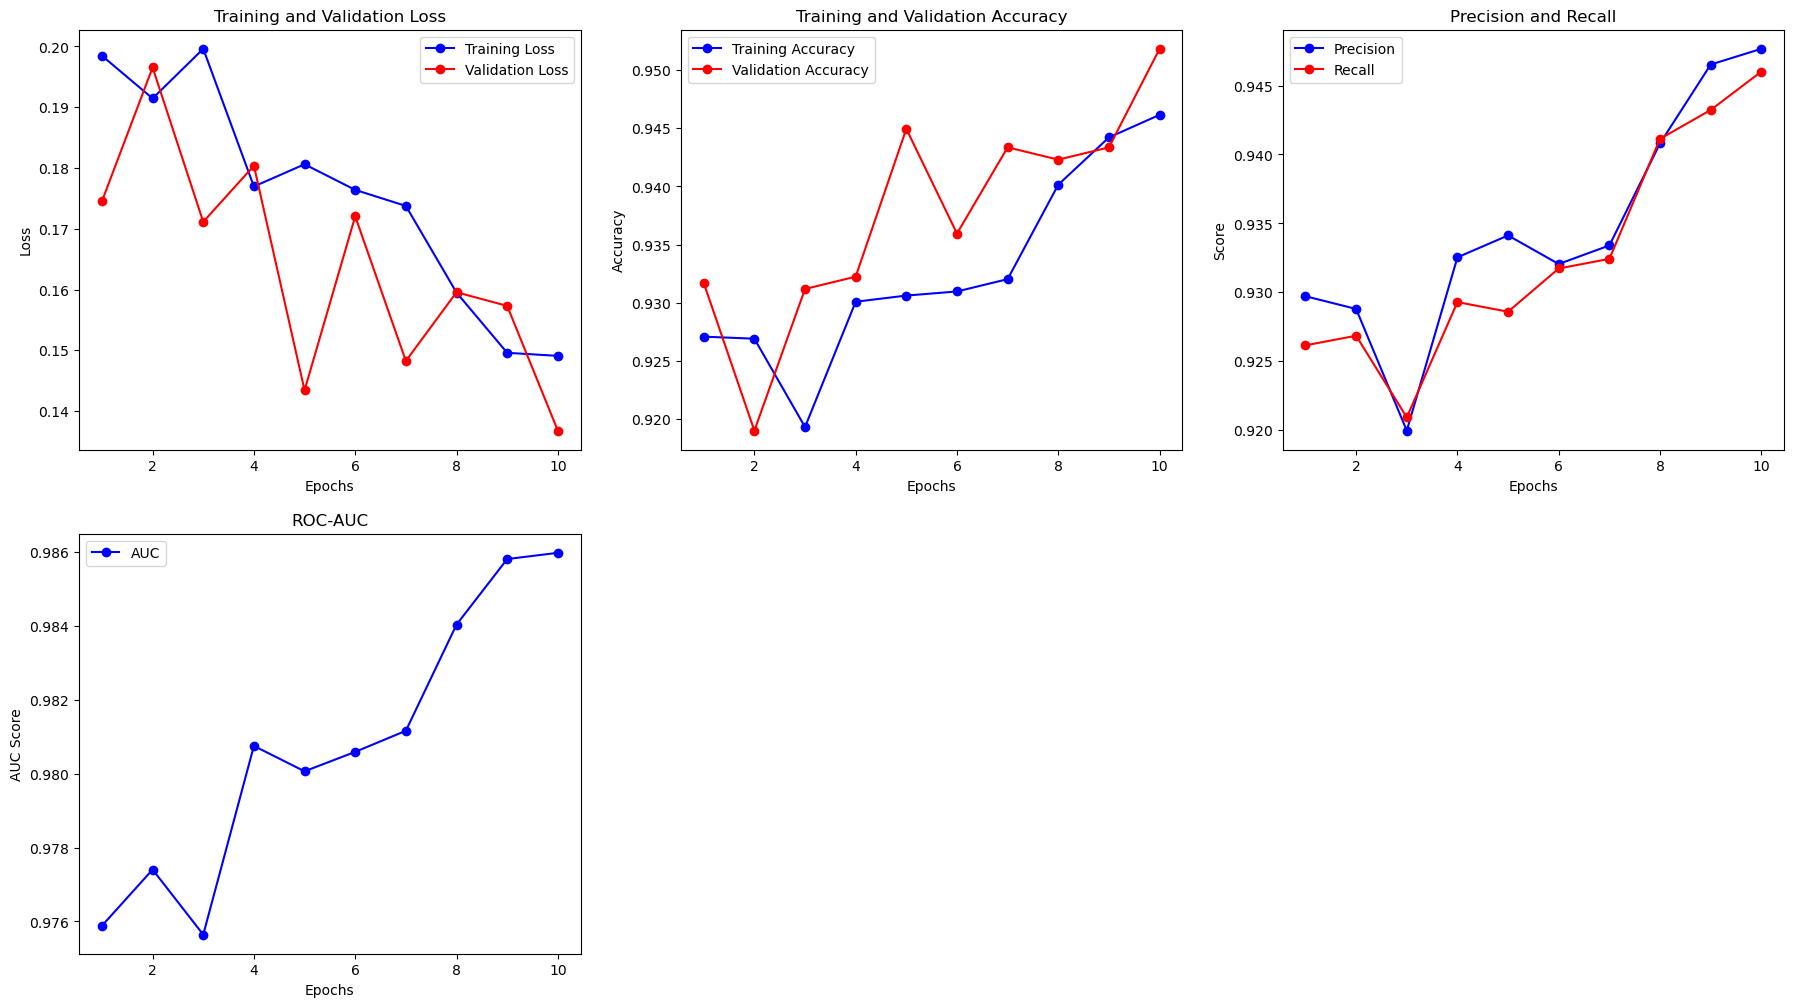

In [61]:
import matplotlib.pyplot as plt

# Assuming history is available
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
precision = history.history['precision_2']
recall = history.history['recall_2']
auc = history.history['auc_3']

# Plotting
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(22, 12))

plt.subplot(2, 3, 1)
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epochs, precision, 'bo-', label='Precision')
plt.plot(epochs, recall, 'ro-', label='Recall')
plt.title('Precision and Recall')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs, auc, 'bo-', label='AUC')
plt.title('ROC-AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()

plt.show()

In [62]:
# Evaluate the model on the test set
evaluation_results = model.evaluate(test_generator)

# Print all evaluation metrics
print("Evaluation Results:", evaluation_results)

# Extract specific metrics if needed
test_loss = evaluation_results[0]
test_accuracy = evaluation_results[1]
precision = evaluation_results[2]
recall = evaluation_results[3]
auc = evaluation_results[4]

print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
print(f'Precision: {precision}, Recall: {recall}, AUC: {auc}')


50/50 [==============================] - 18s 352ms/step - loss: 0.1368 - acc: 0.9518 - precision_2: 0.9676 - recall_2: 0.9363 - auc_3: 0.9896
Evaluation Results: [0.13679930567741394, 0.9518263339996338, 0.9676026105880737, 0.9362591505050659, 0.9895709156990051]
Test Loss: 0.13679930567741394, Test Accuracy: 0.9518263339996338
Precision: 0.9676026105880737, Recall: 0.9362591505050659, AUC: 0.9895709156990051


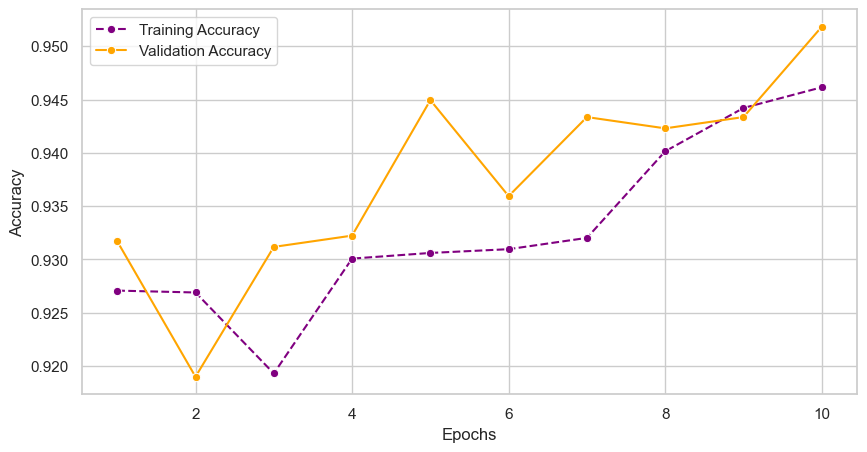

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn style
sns.set(style="whitegrid")
# Set a custom Seaborn color palette
custom_palette = sns.color_palette("husl", as_cmap=True)

# Variation 2: Red dashes for training accuracy, solid red line for validation accuracy
plt.figure(figsize=(10, 5))
sns.lineplot(x=epochs, y=training_accuracy, marker='o', linestyle='dashed', label='Training Accuracy', color='purple')
sns.lineplot(x=epochs, y=validation_accuracy, marker='o', label='Validation Accuracy', color='orange')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

### Following resons for above problem of validation accuracy greater than training accuracy

1. **Small Validation Set:** With a small validation set, there's a higher likelihood of the model encountering samples during validation that are similar to those seen during training, leading to higher accuracy.

2. **Randomness and Variability :** The performance on a small dataset can be more subject to randomness. The validation accuracy may vary between different runs of the validation set, and sometimes the model might perform unusually well.

In [64]:
# Save the model using Keras
model.save("FaceMask_Detection.h5")

In [ ]:
# from keras.models import model_from_json

# # Load the model architecture from JSON file
# with open("FaceMask_Detection_model_t_104.json", "r") as json_file:
#     loaded_model_json = json_file.read()

# # Create the model based on the loaded architecture
# loaded_model = model_from_json(loaded_model_json)

# # Load the weights into the model
# loaded_model.load_weights("FaceMask_Detection_weights_t_104.h5")

# # Compile the loaded model (you need to compile it before using)
# loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [4]:
# Install necessary libraries
!pip install keras opencv-python

# Imports
import cv2
import numpy as np
from keras.models import load_model

# Load the saved model
loaded_model = load_model("FaceMask_Detection104.h5")

In [ ]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# # Save the model to Google Drive
# model.save("/content/drive/MyDrive/FaceMask_Detection.h5")

# from keras.models import load_model

# # Load the model from Google Drive
# loaded_model = load_model("/content/drive/MyDrive/FaceMask_Detection.h5")

In [5]:
import os
import sys
cascade_path = 'haarcascade_frontalface_default.xml'

if not os.path.isfile(cascade_path):
    print(f"Error: Haar Cascade file not found at {cascade_path}.")
    sys.exit()

## **7. WebCam :**

In [6]:
# WebCam
# To detect face by frontal face detection or multiface detection
# Importing necessary modules
import sys
import cv2
import numpy as np

# Load the HarrCascade xml file
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Check if the classifier is empty
if classifier.empty():
    print("Error: Haar Cascade Classifier not loaded successfully.")
    sys.exit()

# Output classes label (Defining Labels)
labels_dict = {0: 'without_mask', 1: 'with_mask'}
color_dict = {0: (0, 0, 255), 1: (0, 255, 0)}  # for red and green respectively

In [7]:
classifier

< cv2.CascadeClassifier 000001E14865ADD0>

In [12]:
import time
# We are creating a function
# Detecting Mask on video or WebCam
def detectOnVidNew():
    # function to detect face mask within a Video or WebCam
    video = cv2.VideoCapture(0)

    if not video.isOpened():
        print("Error: Could not open video capture.")
        sys.exit()
    
    # Initialize a flag to check if an image has been saved
    image_saved = False
    max_faces  = 0

    # loop over video or cam frames
    start_time = time.time()
    while True:
        # Get video frames
        success, frame = video.read()

        # if there is no frame, stop
        if not success:
            break
#         print("Frame read successfully. Shape:", frame.shape)

        # convert frame to grayscale
        img_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect face within image
        faces = classifier.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=3)

        
        num_faces = len(faces)
        if num_faces > max_faces:
            max_faces = num_faces

        # Loop over Faces and Draw rectangle around each face
        for f in faces:
            
            # Adjust the size of the region of interest
            margin = 20  # You can adjust this value based on your preference

            (x, y, w, h) = f
            # Expand the region of interest by adding a margin
            x = max(0, x - margin)
            y = max(0, y - margin)
            w = min(frame.shape[1] - x, w + 4 * margin) #4
            h = min(frame.shape[0] - y, h + 4 * margin) #4 for the face_detection.h5

            # Extract the expanded region of interest
            face_img = frame[y:y+h, x:x+w]

            # Resize the face image
            resized = cv2.resize(face_img, (150, 150))

            # Normalize the face image
            normalized = resized / 255.0

            # Reshape Face image
            reshaped = np.reshape(normalized, (1, 150, 150, 3))
            reshaped = np.vstack([reshaped])

            # Get the model detection results & its label
            # we are loading the model
            result = loaded_model.predict(reshaped)
            print("Raw Prediction:", result)
            label = np.argmax(result, axis=1)[0]
            
            # Threshold Adjustment
            threshold = 0.3326 # Adjust this value based on your observations
            label = 1 if result > threshold else 0

            # Draw Bounding box and output class
            cv2.rectangle(frame, (x, y), (x+w, y+h), color_dict[label], 2)
            cv2.rectangle(frame, (x, y-40), (x+w, y), color_dict[label], -1)
            cv2.putText(frame, labels_dict[label], (x+10, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255))
            print("Label:", label)
            # Save the image when a face is detected and prediction is made
            # Check if an image has already been saved
            if not image_saved:
                # Save the image
                filename = f"detected_face_{labels_dict[label]}.png"
                cv2.imwrite(filename, frame)
                # Set the flag to True after saving the image
                image_saved = True

        # Show the Image
        cv2.imshow("Face Mask Detection", frame)
        
        # Break the loop if the user closes the window
        if cv2.getWindowProperty("Face Mask Detection", cv2.WND_PROP_VISIBLE) < 1:
            break

        # Break the loop after 10 seconds
        if time.time() - start_time > 20:
            break

        # Fix typo: it should be waitKey, not waitkey
        if cv2.waitKey(5) & 0xFF == 27:
            break

    # Stop the Video or Cam
    print(f"Total faces detected: {max_faces}")  # Print the number of detected faces
    print("Closing video feed.")
    video.release()
    cv2.destroyAllWindows()

## **8. Detection :**

In [13]:
detectOnVidNew()

1/1 [==============================] - 0s 32ms/step
Raw Prediction: [[0.41961232]]
Label: 1
1/1 [==============================] - 0s 41ms/step
Raw Prediction: [[0.2839421]]
Label: 0
1/1 [==============================] - 0s 32ms/step
Raw Prediction: [[0.32216913]]
Label: 0
1/1 [==============================] - 0s 32ms/step
Raw Prediction: [[0.34703997]]
Label: 1
1/1 [==============================] - 0s 31ms/step
Raw Prediction: [[0.34703997]]
Label: 1
1/1 [==============================] - 0s 45ms/step
Raw Prediction: [[0.32753494]]
Label: 0
1/1 [==============================] - 0s 29ms/step
Raw Prediction: [[0.3541303]]
Label: 1
1/1 [==============================] - 0s 40ms/step
Raw Prediction: [[0.3399142]]
Label: 1
1/1 [==============================] - 0s 34ms/step
Raw Prediction: [[0.33861867]]
Label: 1
1/1 [==============================] - 0s 17ms/step
Raw Prediction: [[0.32632253]]
Label: 0
1/1 [==============================] - 0s 37ms/step
Raw Prediction: [[0.32973412]]


In [11]:
""" for without mask:
Mean: 0.204798
Median: 0.1964748
Mode: No mode (all values are unique)
Average: 0.204798"""


"""for without mask:
Mean: 0.458021717755102
Median: 0.46867886
Mode: No mode (all values are unique)"""

#he mean, average, and median for the given "mean" values of [0.204798, 0.458021717755102] are all approximately 0.3314,
#while the mean, average, and median for the provided "median" values of [0.1964748, 0.46867886] are approximately 0.3326

# take threshold value as 0.3326

'for without mask:\nMean: 0.458021717755102\nMedian: 0.46867886\nMode: No mode (all values are unique)'

In [13]:
# To check if the webcam is active or not
import cv2

# Function to check if the webcam is available
def check_webcam():
    # Try to access the webcam
    cap = cv2.VideoCapture(0)

    # Check if the webcam is opened successfully
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return False
    else:
        print("Webcam is available.")
        return True

# Call the function to check the webcam
check_webcam()


Webcam is available.


True